# Parameters

In [0]:
source_folder = '/content/drive/My Drive/COMP_4211_Project/Data/Phase_1'
destination_folder = '/content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT'

# Libraries

In [2]:
!pip install transformers

     |████████████████████████████████| 645kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 11.9MB/s 
     |████████████████████████████████| 3.8MB 16.9MB/s 
     |████████████████████████████████| 890kB 30.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=0efa43ad09714252a04fa9848ee8881b9c87c8503f0a1737bfaf174087f27d72
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from transformers import AlbertTokenizer, AlbertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Preliminaries

In [5]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v1')

In [6]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (725 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (741 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (556 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (825 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

# Models

In [0]:
class ALBERT_Single(nn.Module):

    def __init__(self):
        super(ALBERT_Single, self).__init__()

        options_name = "albert-base-v1"
        self.encoder = AlbertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [0]:
class OurClassifier(nn.Module):

    def __init__(self, dimension):
        super(OurClassifier, self).__init__()

        self.fc = nn.Linear(dimension, 1)

    def forward(self, x):
        x = self.fc(x)
        x = torch.squeeze(x, 1)
        x = torch.sigmoid(x)

        return x

In [0]:
class ALBERT_Double(nn.Module):

    def __init__(self):
        super(ALBERT_Double, self).__init__()

        options_name = "albert-base-v1"
        self.encoder1 = AlbertForSequenceClassification.from_pretrained(options_name)
        self.encoder2 = AlbertForSequenceClassification.from_pretrained(options_name)
        self.classifier = OurClassifier(4)

    def forward(self, title, text, label):
        title_loss, title_fea = self.encoder1(title, labels=label)[:2]
        text_loss, text_fea = self.encoder2(text, labels=label)[:2]

        total_fea = torch.cat((title_fea, text_fea), 1)
        total_out = self.classifier(total_fea)

        return total_out

# Training

In [0]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [0]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf"),
          version = 'title'):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text, titletext), _ in train_loader:

            if version == 'title':
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                title = title.type(torch.LongTensor)  
                title = title.to(device)
                output = model(title, labels)
                loss, _ = output
            elif version == 'text':
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)
                loss, _ = output
            elif version == 'titletext':
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)
                loss, _ = output
            else:
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                title = title.type(torch.LongTensor)  
                title = title.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(title, text, labels)
                labels = labels.type(torch.FloatTensor)           
                labels = labels.to(device)
                output = output.type(torch.FloatTensor)           
                output = output.to(device)
                loss = criterion(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, title, text, titletext), _ in valid_loader:

                        if version == 'title':
                            labels = labels.type(torch.LongTensor)           
                            labels = labels.to(device)
                            title = title.type(torch.LongTensor)  
                            title = title.to(device)
                            output = model(title, labels)
                            loss, _ = output
                        elif version == 'text':
                            labels = labels.type(torch.LongTensor)           
                            labels = labels.to(device)
                            text = text.type(torch.LongTensor)  
                            text = text.to(device)
                            output = model(text, labels)
                            loss, _ = output
                        elif version == 'titletext':
                            labels = labels.type(torch.LongTensor)           
                            labels = labels.to(device)
                            titletext = titletext.type(torch.LongTensor)  
                            titletext = titletext.to(device)
                            output = model(titletext, labels)
                            loss, _ = output
                        else:
                            labels = labels.type(torch.LongTensor)           
                            labels = labels.to(device)
                            title = title.type(torch.LongTensor)  
                            title = title.to(device)
                            text = text.type(torch.LongTensor)  
                            text = text.to(device)
                            output = model(title, text, labels)
                            labels = labels.type(torch.FloatTensor)           
                            labels = labels.to(device)
                            output = output.type(torch.FloatTensor)           
                            output = output.to(device)
                            loss = criterion(output, labels)
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + version + '_model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/' + version + '_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + version + '_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

## Title only

In [21]:
model_title = ALBERT_Single().to(device)
optimizer = optim.Adam(model_title.parameters(), lr=2e-5)

train(model=model_title, optimizer=optimizer, version='title')

Epoch [1/5], Step [142/1420], Train Loss: 0.6927, Valid Loss: 0.6790
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/title_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/title_metrics.pt
Epoch [1/5], Step [284/1420], Train Loss: 0.6209, Valid Loss: 1.0199
Epoch [2/5], Step [426/1420], Train Loss: 0.6246, Valid Loss: 0.5573
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/title_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/title_metrics.pt
Epoch [2/5], Step [568/1420], Train Loss: 0.4963, Valid Loss: 0.9135
Epoch [3/5], Step [710/1420], Train Loss: 0.5241, Valid Loss: 0.4531
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/title_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/title_metrics.pt
Epoch [3/5], Step [852/1420], Train Loss: 0.3843, Valid Loss:

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/title_metrics.pt


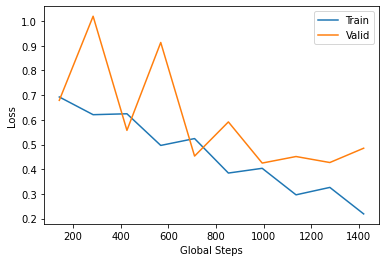

In [22]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/title_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

## Text only

In [0]:
model_text = ALBERT_Single().to(device)
optimizer = optim.Adam(model_text.parameters(), lr=2e-5)

train(model=model_text, optimizer=optimizer, version='text')

Epoch [1/5], Step [142/1420], Train Loss: 0.4146, Valid Loss: 0.2302
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/text_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/text_metrics.pt
Epoch [1/5], Step [284/1420], Train Loss: 0.2015, Valid Loss: 0.2724
Epoch [2/5], Step [426/1420], Train Loss: 0.2878, Valid Loss: 0.1553
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/text_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/text_metrics.pt
Epoch [2/5], Step [568/1420], Train Loss: 0.1017, Valid Loss: 0.1777
Epoch [3/5], Step [710/1420], Train Loss: 0.1565, Valid Loss: 0.1386
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/text_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/text_metrics.pt
Epoch [3/5], Step [852/1420], Train Loss: 0.0609, Valid Loss: 0.126

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/text_metrics.pt


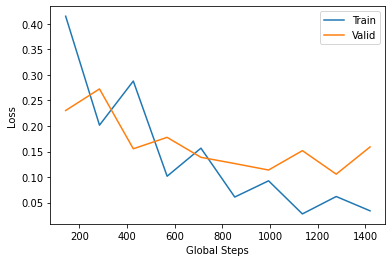

In [0]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/text_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

## Title-text Concatenation

In [0]:
model_titletext = ALBERT_Single().to(device)
optimizer = optim.Adam(model_titletext.parameters(), lr=2e-5)

train(model=model_titletext, optimizer=optimizer, version='titletext')

Epoch [1/5], Step [142/1420], Train Loss: 0.4473, Valid Loss: 0.2801
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/titletext_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/titletext_metrics.pt
Epoch [1/5], Step [284/1420], Train Loss: 0.2065, Valid Loss: 0.2856
Epoch [2/5], Step [426/1420], Train Loss: 0.2817, Valid Loss: 0.1692
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/titletext_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/titletext_metrics.pt
Epoch [2/5], Step [568/1420], Train Loss: 0.0914, Valid Loss: 0.1698
Epoch [3/5], Step [710/1420], Train Loss: 0.1981, Valid Loss: 0.2173
Epoch [3/5], Step [852/1420], Train Loss: 0.0600, Valid Loss: 0.1811
Epoch [4/5], Step [994/1420], Train Loss: 0.1965, Valid Loss: 0.1489
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/titletext_model.pt
Mod

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/titletext_metrics.pt


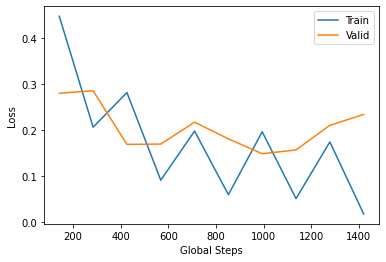

In [0]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/titletext_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

## Title and Text

In [12]:
model_titleandtext = ALBERT_Double().to(device)
optimizer = optim.Adam(model_titleandtext.parameters(), lr=2e-5)

train(model=model_titleandtext, optimizer=optimizer, version='titleandtext')


Epoch [1/5], Step [142/1420], Train Loss: 0.4773, Valid Loss: 0.3789
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/titleandtext_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/titleandtext_metrics.pt
Epoch [1/5], Step [284/1420], Train Loss: 0.2338, Valid Loss: 0.3805
Epoch [2/5], Step [426/1420], Train Loss: 0.3467, Valid Loss: 0.1976
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/titleandtext_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/titleandtext_metrics.pt
Epoch [2/5], Step [568/1420], Train Loss: 0.1333, Valid Loss: 0.1930
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/titleandtext_model.pt
Model saved to ==> /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/titleandtext_metrics.pt
Epoch [3/5], Step [710/1420], Train Loss: 0.2565, Valid Loss: 0.1692
Model saved to ==>

Model loaded from <== /content/drive/My Drive/COMP_4211_Project/Models/Phase_1/ALBERT/titleandtext_metrics.pt


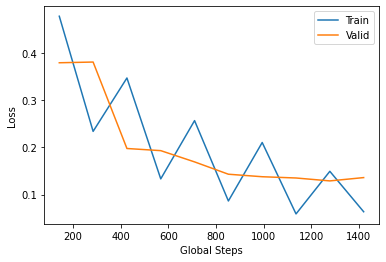

In [15]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/titleandtext_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Evaluation

In [0]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text, titletext), _ in test_loader:

            if version == 'title':
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                title = title.type(torch.LongTensor)  
                title = title.to(device)
                output = model(title, labels)

            elif version == 'text':
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

            elif version == 'titletext':
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)

            else:
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                title = title.type(torch.LongTensor)  
                title = title.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(title, text, labels)

            if version == 'title' or version == 'text' or version == 'titletext':
                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
            else:
                output = (output > threshold).int()
                y_pred.extend(output.tolist())
                y_true.extend(labels.tolist())
            # output = (output > threshold).int()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Classification Report:
              precision    recall  f1-score   support

           1     0.7474    0.9265    0.8274       313
           0     0.9053    0.6918    0.7843       318

    accuracy                         0.8082       631
   macro avg     0.8264    0.8092    0.8059       631
weighted avg     0.8270    0.8082    0.8057       631



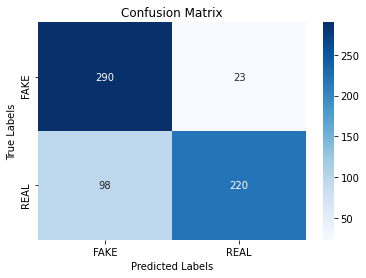

In [23]:
evaluate(model_title, test_iter, version='title')

Classification Report:
              precision    recall  f1-score   support

           1     0.9732    0.9265    0.9493       313
           0     0.9309    0.9748    0.9524       318

    accuracy                         0.9509       631
   macro avg     0.9520    0.9507    0.9508       631
weighted avg     0.9519    0.9509    0.9508       631



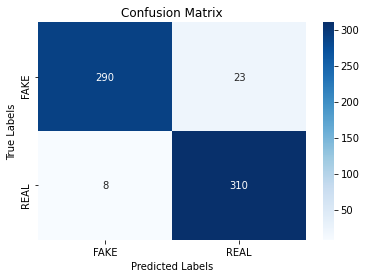

In [0]:
evaluate(model_text, test_iter, version='text')

Classification Report:
              precision    recall  f1-score   support

           1     0.9205    0.9617    0.9406       313
           0     0.9605    0.9182    0.9389       318

    accuracy                         0.9398       631
   macro avg     0.9405    0.9400    0.9398       631
weighted avg     0.9407    0.9398    0.9398       631



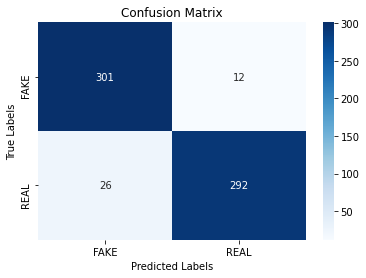

In [0]:
evaluate(model_titletext, test_iter, version='titletext')

Classification Report:
              precision    recall  f1-score   support

           1     0.9896    0.9105    0.9484       313
           0     0.9184    0.9906    0.9531       318

    accuracy                         0.9509       631
   macro avg     0.9540    0.9506    0.9508       631
weighted avg     0.9537    0.9509    0.9508       631



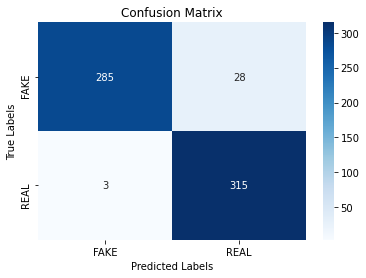

In [14]:
evaluate(model_titleandtext, test_iter, version='titleandtext')